In [2]:
import cv2
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from keras.callbacks import LearningRateScheduler

In [3]:
model = load_model('model.h5',compile=False)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
model.compile(optimizer='adam',loss="categorical_crossentropy", metrics=["accuracy"])

In [5]:
img = cv2.imread('Test.jpg')

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

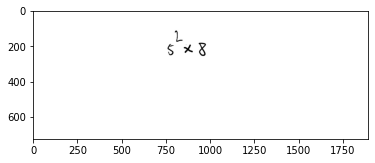

In [7]:
plt.imshow(img)

844 186 69 65
752 183 53 81
928 176 59 92
793 107 62 81


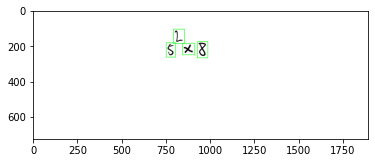

In [8]:
img3 = img.copy()
images=[]
pos=[]

def segmentNumbers(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
    dilation = cv2.dilate(thresh, rect_kernel, iterations = 2)
    cnts = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[0]
    for cnt in cnts:
        x,y,w,h = cv2.boundingRect(cnt)
        img2 = img[y:y+h,x:x+w]
        img2 = cv2.resize(img2,(100,100),interpolation = cv2.INTER_AREA)
        images.append(img2)
        pos.append([x,y])
        print(x,y,w,h)      #for illustration
        rect = cv2.rectangle(img3, (x, y), (x + w, y + h),(0, 255, 0), 2)       #for illustration

segmentNumbers(img)
plt.imshow(img3)

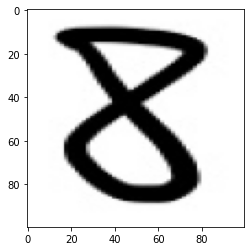

In [9]:
plt.imshow(images[2])

In [10]:
def processImage(img):
    #img = cv2.imread(path)
#img = cv2.copyMakeBorder(img, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=(255,255,255))
    img = cv2.resize(img,(100,100))
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = img.astype('float32')
    img /= 255
    return img

In [11]:
x = processImage(images[2])

In [12]:
y = model.predict(x,callbacks=[annealer])

In [13]:
labels = ['zero','one','two','three','four','five','six','seven','eight','nine','minus','plus','equal','div','decimal','times']
print(labels[np.argmax(y)])

eight


In [14]:
j = 0

for i in images:
    x = processImage(i)
    y = model.predict(x,callbacks=[annealer])
    label = labels[np.argmax(y)]
    pos[j].append(label)
    j += 1
    print(label)


times
five
eight
two


In [15]:
pos = sorted(pos)
print(pos)

[[752, 183, 'five'], [793, 107, 'two'], [844, 186, 'times'], [928, 176, 'eight']]


In [49]:
def preprocess_func(pos):
    string_to_num = {'zero' : '0', 'one' : '1', 'two' : '2', 'three' : '3', 'four' : '4', 'five' : '5', 'six' : '6', 'seven' : '7','eight' : '8', 'nine' : '9','minus' : '-','plus' : '+','equal' : '=','div' : '/','times' : '*'}
    num = ''
    s = ''
    for i in range(len(pos)):
        if pos[i][-1] in string_to_num:
            if i >= 1 and pos[i-1][1] - pos[i][1] >= 50:
                s += num
                s += '**'
                num = ''
            num += string_to_num[pos[i][-1]]
        else:
            s += num
            s += string_to_num[pos[i][-1]]
            num = ''
    s += num
    return s

pre_out = preprocess_func(pos)
out = pd.eval(pre_out)
print(out)

200
